# Object detection demo
This notebook tests some object detection algorithms on static images, such as Faster-CNN, YOLO, on the Oxford III Pet Dataset. First load modules.

In [312]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes

from PIL import Image


## Download Oxford III Pet Dataset
Download dataset into `test_datasets/' directory.

In [314]:
pet_dataset = torchvision.datasets.OxfordIIITPet(root="./test_datasets", 
                                                 target_types="segmentation",
                                                 download=True)

In [317]:
pet_dataset

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./test_datasets

In [318]:
N = len(pet_dataset)

In [319]:
idx=np.random.randint(N)
idx

515

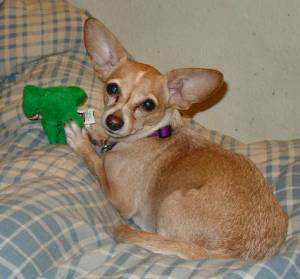

In [320]:
pet_dataset[idx][0]

# Build custom dataset and dataloader
Here create custom dataset to load files as required. Currently just testing the pre-trained networks, so we are not loading the bounding boxes (in annotations).

In [293]:
class PetsDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.images = [fname for fname in 
                       os.listdir(os.path.join(root, "images/")) 
                       if fname.endswith('.jpg')]
        self.annotations = [fname for fname in 
                            os.listdir(os.path.join(root, "annotations/trimaps/")) 
                            if fname.endswith('.png')]
        self.transform = transform
        
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        fname = self.images[i]
        fpath = os.path.join(self.root, "images/", fname)
        img = self.transform(open_image(fpath))
        #TODO: load annotations 
        #fname = self.annotations[i]
        #fpath = os.path.join(self.root, "annotations/trimaps/", fname)
        #bbox = open_image(fpath)
        return img #, bbox
    
    

In [294]:
# Open data as tensor
pet_data = PetsDataset(root="./test_datasets/oxford-iiit-pet", 
                       transform = transforms.ToTensor())

In [295]:
pet_data[0].size()

torch.Size([3, 275, 183])

In [296]:
batch_size = 1       # Each image is different size, so have to run algorithm with batch size = 1.
pet_dataloader = DataLoader(pet_data, batch_size, shuffle=True)


In [297]:
example_image = next(iter(pet_dataloader))

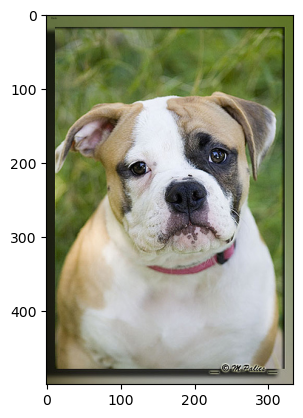

In [321]:
plt.imshow(  example_image[0].permute(1, 2, 0)  )

# Load pre-trained model
Start by loading Faster RCNN with fasterrcnn_resnet50_fpn

In [276]:
fasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

In [277]:
fasterRCNN.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Run model on our example

In [323]:
%time example_output = fasterRCNN(example_image)

CPU times: user 1.27 s, sys: 1.2 s, total: 2.46 s
Wall time: 1.11 s


In [324]:
example_image, example_output

(tensor([[[[0.4000, 0.3961, 0.3922,  ..., 0.3725, 0.3725, 0.3686],
           [0.3843, 0.3843, 0.3922,  ..., 0.3725, 0.3686, 0.3686],
           [0.3922, 0.3882, 0.4000,  ..., 0.3686, 0.3686, 0.3686],
           ...,
           [0.3412, 0.3451, 0.3490,  ..., 0.6314, 0.6314, 0.6314],
           [0.3412, 0.3451, 0.3490,  ..., 0.6314, 0.6314, 0.6314],
           [0.3412, 0.3451, 0.3529,  ..., 0.6314, 0.6314, 0.6314]],
 
          [[0.4549, 0.4510, 0.4471,  ..., 0.4549, 0.4549, 0.4510],
           [0.4392, 0.4392, 0.4471,  ..., 0.4549, 0.4510, 0.4510],
           [0.4471, 0.4431, 0.4549,  ..., 0.4510, 0.4510, 0.4510],
           ...,
           [0.3294, 0.3333, 0.3373,  ..., 0.6196, 0.6196, 0.6196],
           [0.3294, 0.3333, 0.3373,  ..., 0.6196, 0.6196, 0.6196],
           [0.3294, 0.3333, 0.3412,  ..., 0.6196, 0.6196, 0.6196]],
 
          [[0.2549, 0.2588, 0.2549,  ..., 0.1529, 0.1529, 0.1490],
           [0.2471, 0.2471, 0.2549,  ..., 0.1529, 0.1490, 0.1490],
           [0.2549, 0.25

## Plot output

In [327]:
def plot_image_with_boxes(my_img, my_boxes):
    """my_img is torch tensor floats
    """
    my_img_RGB = my_img.mul(255).add_(0.5).clamp_(0, 255).type(torch.uint8)
    image_with_box = draw_bounding_boxes(my_img_RGB, my_boxes,
                                        width=4)
    plt.imshow(transforms.ToPILImage()(image_with_box))


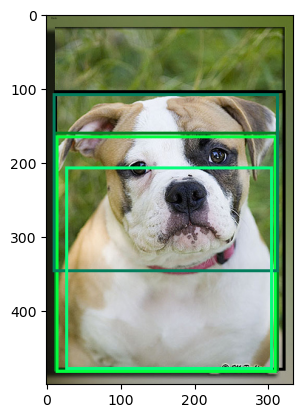

In [328]:
plot_image_with_boxes(example_image[0], example_output[0]['boxes'].detach())